# Animate the nonstationary internal tide fields


In [1]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm


from sfoda.utils.barycentric import BarycentricInterp
from sfoda.utils.myproj import MyProj
from sfoda.utils.otherplot import axcolorbar

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import rcParams

from s3fs import S3FileSystem, S3Map

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

In [3]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-ubuntu/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [18]:

# f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_spacechunk.zarr/", s3=s3)
# f2 = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_spacechunk.zarr/", s3=s3)
f = S3Map('uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered.zarr', s3=s3)
f2 = S3Map('uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_seasonaltides.zarr', s3=s3)
ds = xr.open_dataset(f, engine='zarr', chunks={})
ds2 = xr.open_dataset(f2, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values
ds2.suntans.xv=ds2.xv.values
ds2.suntans.yv=ds2.yv.values
ds, ds2

Changing the _FillValue from -999999 to 999999
Changing the _FillValue from -999999 to 999999


(<xarray.Dataset>
 Dimensions:       (Nc: 225368, numsides: 8, Nk: 80, time: 8761, Np: 454016)
 Coordinates:
   * time          (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
     z_r           (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
 Dimensions without coordinates: Nc, numsides, Nk, Np
 Data variables:
     cells         (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
     dv            (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
     dz            (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
     eta_bandpass  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
     eta_lowpass   (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
     nfaces        (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
     xp            (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
     xv            (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
     

In [21]:
ds.cells.values

array([[  3058,   3061,   3060, ...,   2803, 999999, 999999],
       [  3056,   3059,   3058, ...,   2805, 999999, 999999],
       [  3054,   3057,   3056, ...,   2807, 999999, 999999],
       ...,
       [316194, 316193, 316158, ..., 316195, 999999, 999999],
       [316196, 316195, 316160, ..., 316197, 999999, 999999],
       [316186, 316183, 316180, ..., 316187, 999999, 999999]], dtype=int32)

In [37]:
def fix_stuff(ds):
    ds.suntans.Nk=np.ones_like(ds.suntans.xv)
    ds.suntans.cells = xr.where(ds.cells==-999999, -1, ds.suntans.cells).values
    ds.suntans.cells = xr.where(ds.cells==999999, -1, ds.suntans.cells).values
    
    ds.suntans.calc_all_properties()
    
    P = MyProj('merc')

    # Convert the suntans coordinates to lat/lon
    ds.suntans.xp, ds.suntans.yp = P.to_ll(ds.xp, ds.yp)
    ds.suntans.xv, ds.suntans.yv = P.to_ll(ds.xv, ds.yv)
    ds.suntans._xy = None # reset this
    
    return ds

ds = fix_stuff(ds)
ds2 = fix_stuff(ds2)

In [40]:
ds.cells.values

array([[  3058,   3061,   3060, ...,   2803, 999999, 999999],
       [  3056,   3059,   3058, ...,   2805, 999999, 999999],
       [  3054,   3057,   3056, ...,   2807, 999999, 999999],
       ...,
       [316194, 316193, 316158, ..., 316195, 999999, 999999],
       [316196, 316195, 316160, ..., 316197, 999999, 999999],
       [316186, 316183, 316180, ..., 316187, 999999, 999999]], dtype=int32)

In [38]:
%%time
tstep=3500
datalow = ds['eta_lowpass'].isel(time=tstep).values
ddx,ddy = ds.suntans.calc_grad(datalow)
gradlow = np.abs(ddx+1j*ddy)
# data = ds['eta_steric_lowpass'].isel(time=tstep).values
#data = (ds2['eta_steric_bandpass'].isel(time=tstep)-ds2['eta_steric_tidal'].isel(time=tstep)).values
data = ds2['eta_non_phase_locked'].isel(time=tstep).values
ddx,ddy = ds2.suntans.calc_grad(data)
gradhigh = np.abs(ddx+1j*ddy)

IndexError: index -999999 is out of bounds for axis 0 with size 679391

/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/sfoda/utils/otherplot.py:448: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # You call fig.tight_layout BEFORE creating the colorbar


CPU times: user 1min 9s, sys: 1.6 s, total: 1min 10s
Wall time: 1min 11s


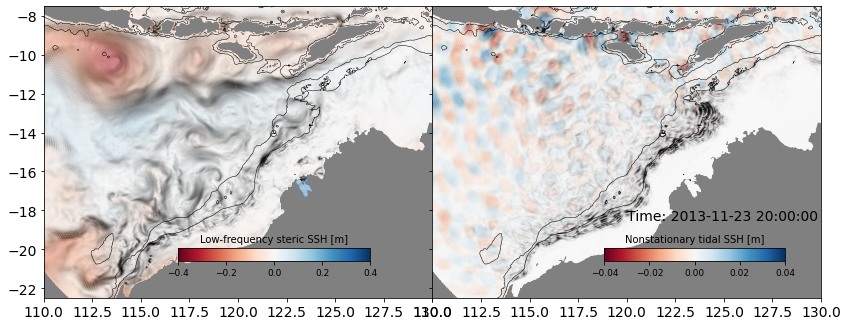

In [6]:
fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(121, facecolor='0.5')
fig,ax,cf1,cb = ds.suntans.plotcelldata(datalow, vmin=-0.4, vmax=0.4, cmap='RdBu', colorbar=False)
_,_,cf1a,_ = ds.suntans.plotcelldata(gradlow, cmap='Greys', alpha=0.2, vmax=0.25, colorbar=False)
ds.suntans.contourf(ds.dv, clevs = [200.,1000.], filled=False, colors='k', linewidths=0.5)

plt.xlim(110,130)
plt.ylim(-22.5,-7.5)

cb=axcolorbar(cf1, pos=[0.35,0.17,0.5,0.04])
cb.ax.set_title('Low-frequency steric SSH [m]', fontsize=10)

#


ax2 = fig.add_subplot(122, facecolor='0.5')
fig,ax,cf2,cb = ds.suntans.plotcelldata(data, vmin=-0.04, vmax=0.04, cmap='RdBu', colorbar=False)
_,_,cf2a,_ = ds.suntans.plotcelldata(gradhigh, cmap='Greys', alpha=0.2, vmin=0, vmax=0.25, colorbar=False)
ds2.suntans.contourf(ds2.dv, clevs = [200.,1000.], filled=False, colors='k', linewidths=0.5)

plt.xlim(110,130)
plt.ylim(-22.5,-7.5)
ax2.set_yticklabels([])

cb=axcolorbar(cf2, pos=[0.4,0.17,0.5,0.04])
cb.ax.set_title('Nonstationary tidal SSH [m]', fontsize=10)

titlestr = 'Time: %s'%(str(ds.time.values[tstep])[0:19].replace('T',' '))
title = ax2.text(120,-18.5,titlestr)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)

In [7]:
%%time
outpath = '../FIGURES/suntans_2km_lowfreq_nonstat_ssh_NovDec2013'
timesteps = slice(3500,3500+35*30)
datalow = ds['eta_lowpass'].isel(time=timesteps).values

# datans = (ds['eta_bandpass'].isel(time=timesteps)-ds['eta_tidal'].isel(time=timesteps)).values
datans = (ds2['eta_steric_bandpass'].isel(time=timesteps)-ds2['eta_steric_tidal'].isel(time=timesteps)).values

time = ds['time'].isel(time=timesteps)


CPU times: user 10.4 s, sys: 5.66 s, total: 16.1 s
Wall time: 13.8 s


In [8]:
#####

# Load the data before
frames  = timesteps.stop - timesteps.start

# Make the animation
def init():
    return cf1, cf1a, cf2, cf2a, title

def update_time(t):
    if t%24==0:
        print(t)
    
    # Calculate the gradient 
    dTdx, dTdy = ds.suntans.calc_grad(datalow[t,:])
    dT = np.abs(dTdx + 1j*dTdy)
    
    cf1.set_array(datalow[t,:])
    cf1.set_edgecolors(cf1.to_rgba(np.array((datalow[t,:]))))
    cf1a.set_array(dT)
    cf1a.set_edgecolors(cf1a.to_rgba(np.array((dT))))
    
    dTdx, dTdy = ds.suntans.calc_grad(datans[t,:])
    dT = np.abs(dTdx + 1j*dTdy)
    
    cf2.set_array(datans[t,:])
    cf2.set_edgecolors(cf2.to_rgba(np.array((datans[t,:]))))
    cf2a.set_array(dT)
    cf2a.set_edgecolors(cf2a.to_rgba(np.array((dT))))
    
    fig.canvas.draw()

    #title.set_text('Year Day: %3.2f'%(t) )
    titlestr = 'Time: %s'%(str(time.values[t])[0:19].replace('T',' '))

    title.set_text(titlestr)


    return cf1,cf1a, cf2, cf2a, title


#timedays =  [0,0.1,0.2]
#timedays = np.arange(0,2,1/48.)
#timedays = np.arange(0,28,1/48.)
anim = animation.FuncAnimation(fig, update_time,\
    init_func=init, frames=frames,  blit=True)
    #init_func=init, frames=[1,2], interval=50, blit=True)


#anim.save("%s.gif"%outpath,writer='imagemagick',fps=12, dpi=90)

# Set up formatting for the movie files
# Writer = animation.writers['ffmpeg_file']
# writer = Writer(fps=24, metadata=dict(artist='Matt Rayson'), bitrate=3600, codec='mpeg4')

# anim.save("%s.avi"%outpath, writer=writer)
# print('Saved to %s.avi'%outpath)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg_file']
writer = Writer(fps=12, metadata=dict(artist='Matt Rayson'), bitrate=14400, codec='libx264',
               extra_args=['-preset','veryslow','-crf','10','-pix_fmt', 'yuv420p'])
# writer = Writer(fps=12, metadata=dict(artist='Matt Rayson'), bitrate=14400, codec='ffv1')
               #extra_args="-c:v libx264 -preset veryslow -crf 10 -pix_fmt yuv420p")

anim.save("%s.mp4"%outpath, writer=writer, dpi=150)
print('Saved to %s.mp4'%outpath)

0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
720
744
768
792
816
840
864
888
912
936
960
984
1008
1032
Saved to ../FIGURES/suntans_2km_lowfreq_nonstat_ssh_NovDec2013.mp4


CPU times: user 2.87 s, sys: 393 ms, total: 3.26 s
Wall time: 3.16 s


Text(0.5, 1.0, 'Nonstationary tidal SSH [m]')

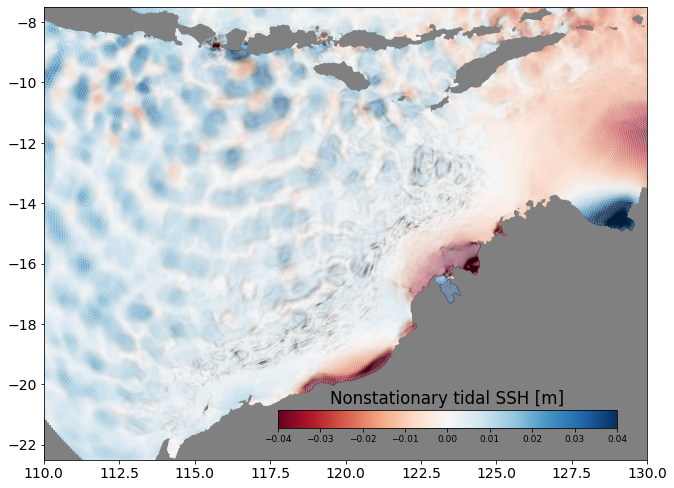

In [92]:
%%time
# data = (ds['eta_steric_bandpass'].isel(time=tstep)-ds['eta_steric_tidal'].isel(time=tstep)).values
data = (ds['eta_bandpass'].isel(time=tstep)-ds['eta_tidal'].isel(time=tstep)).values
ddx,ddy = ds.suntans.calc_grad(data)


fig = plt.figure(figsize=(10,7))
fig.add_subplot(111, facecolor='0.5')
fig,ax,cf,cb = ds.suntans.plotcelldata(data, vmin=-0.04, vmax=0.04, cmap='RdBu', colorbar=False)
ds.suntans.plotcelldata(np.abs(ddx+1j*ddy), cmap='Greys', alpha=0.2, vmin=0, vmax=0.25, colorbar=False)
plt.xlim(110,130)
plt.ylim(-22.5,-7.5)

cb=axcolorbar(cf, pos=[0.4,0.07,0.5,0.04])
cb.ax.set_title('Nonstationary tidal SSH [m]')


CPU times: user 2.53 s, sys: 213 ms, total: 2.75 s
Wall time: 2.89 s


Text(0.5, 1.0, 'Stationary internal tide SSH [m]')

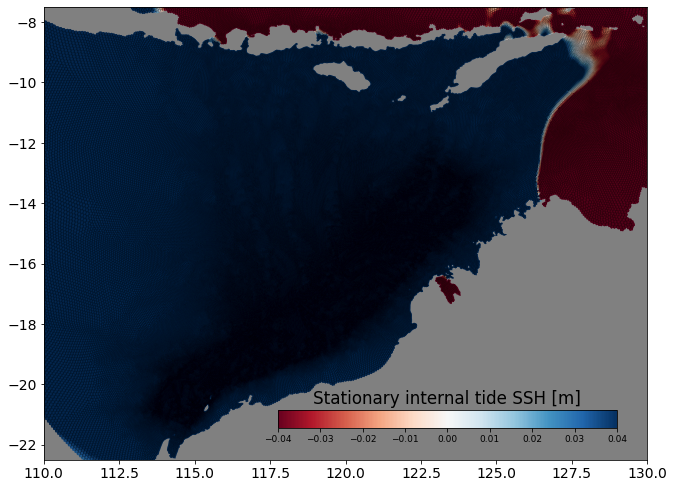

In [88]:
%%time
# data = ds['eta_steric_tidal'].isel(time=tstep).values
data = ds['eta_tidal'].isel(time=tstep).values

ddx,ddy = ds.suntans.calc_grad(data)

fig = plt.figure(figsize=(10,7))
fig.add_subplot(111, facecolor='0.5')
fig,ax,cf,cb = ds.suntans.plotcelldata(data, vmin=-0.04, vmax=0.04, cmap='RdBu', colorbar=False)
ds.suntans.plotcelldata(np.abs(ddx+1j*ddy), cmap='Greys', alpha=0.2, vmin=0, vmax=5e-6, colorbar=False)
plt.xlim(110,130)
plt.ylim(-22.5,-7.5)

cb=axcolorbar(cf, pos=[0.4,0.07,0.5,0.04])
cb.ax.set_title('Stationary internal tide SSH [m]')